<a href="https://colab.research.google.com/github/cristiandarioortegayubro/UNI/blob/main/colab/UNI_Forecasting_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

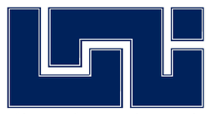

</center>

<h1><b>
Dirección de Estudios de Posgrado y Educación Continua
<h2><b>
Analítica Predictiva y Machine Learning con R, Python y Databricks

[UNI-DEPEC](https://posgrado.uni.edu.ni)

<h1><b>
Forecasting


Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

## Instalando las librerías necesarias

In [1]:
!pip install pandas_datareader

In [2]:
!pip install skforecast

## Activando las librerías necesarias

### Para las alertas

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Para el análisis de datos y el conjunto de datos

In [4]:
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web

### Para forecasting

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

###Para gráficos

In [7]:
import plotly.express as px
import plotly.graph_objects as go

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

## Conjunto de datos

Se dispone de una serie temporal con la demanda eléctrica (MW) del estado de Victoria (Australia) desde 2011-12-31 al 2014-12-31. Se pretende generar un modelo de forecasting capaz de predecir la demanda energética del día siguiente a nivel horario.

In [22]:
url = "https://raw.githubusercontent.com/cristiandarioortegayubro/UNI/main/datos.csv"
datos = pd.read_csv(url)
datos.drop(columns="Unnamed: 0", inplace=True)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


La columna Time se ha almacenado como string. Para convertirla en datetime, se emplea la función pd.to_datetime(). Una vez en formato datetime, y para hacer uso de las funcionalidades de pandas, se establece como índice. Además, dado que los datos se han registrado cada 30 minutos, se indica la frecuencia ('30min').

### Conversión del formato fecha

In [23]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa.

In [25]:
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

Aunque los datos se encuentran en intervalos de 30 minutos, el objetivo es crear un modelo capaz de predecir la demanda eléctrica a nivel horario, por lo que se tienen que agregar los datos. Este tipo de transformación es muy sencillas si se combina el índice de tipo temporal de pandas y su método resample().

Es muy importante utilizar correctamente los argumentos closed='left' y label='right' para no introducir en el entrenamiento información a futuro (leakage)). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

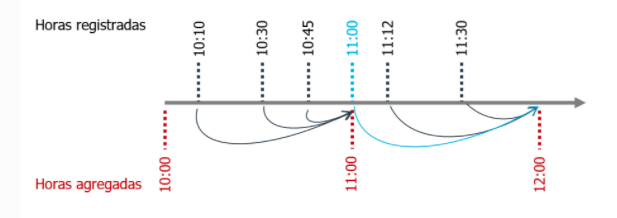

Para el valor promedio de las 11:00 no se incluye el valor puntual de las 11:00 por que, en la realidad, en ese momento exacto no se dispone todavía del valor.

In [26]:
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


El set de datos empieza el 2011-12-31 14:00:00 y termina el 2014-12-31 13:00:00. Se descartan los primeros 10 y los últimos 13 registros para que empiece el 2012-01-01 00:00:00 y termine el 2014-12-30 23:00:00. Además, para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

## Generación del Modelo

### División del conjunto de datos

In [27]:
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'

In [28]:
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

In [29]:
print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00


### Exploración Gráfica

Cuando se quiere generar un modelo de forecasting, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

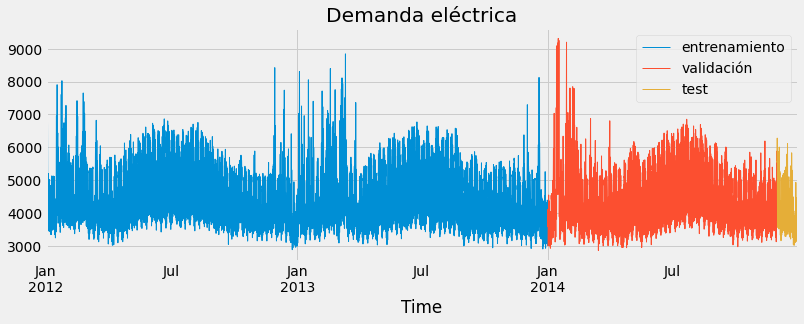

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

El gráfico anterior muestra que la demanda eléctrica tiene estacionalidad anual. Se observa un incremento centrado en el mes de Julio y picos de demanda muy acentuados entre enero y marzo.


### Selección de la serie temporal

Debido a la varianza de la serie temporal, no es posible apreciar con un solo gráfico el posible patrón intradiario.

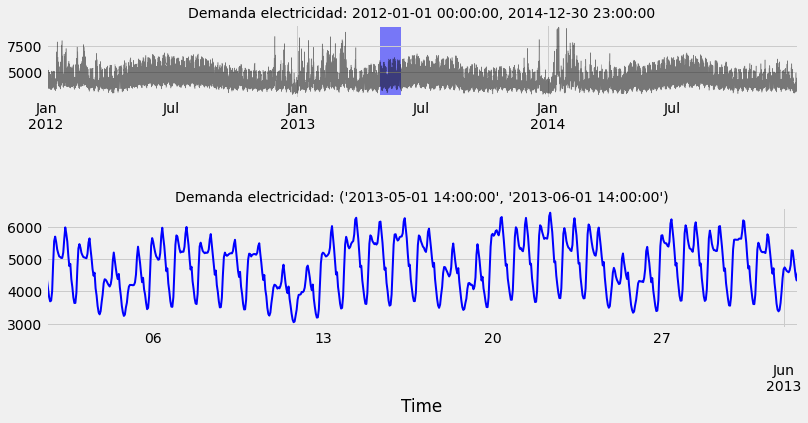

In [32]:
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Al aplicar zoom sobre la serie temporal, se hace patente una clara estacionalidad semanal, con consumos más elevados durante la semana laboral (lunes a viernes) y menor en los fines de semana. Se observa también que existe una clara correlación entre el consumo de un día con el del día anterior.

### Estacionalidad anual, semanal y diaria

#### Anual

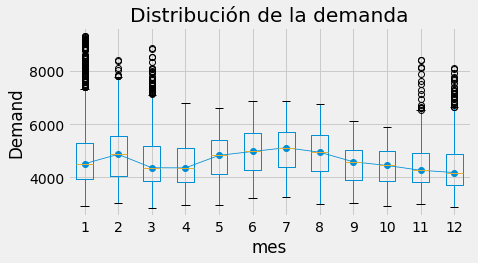

In [34]:
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución de la demanda')
fig.suptitle('');

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

#### Semanal

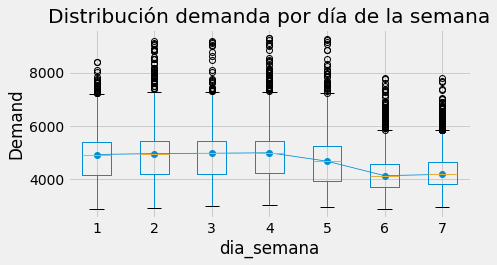

In [35]:
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se aprecia una estacionalidad semanal, con valores de demanda inferiores durante el fin de semana.

#### Diaria

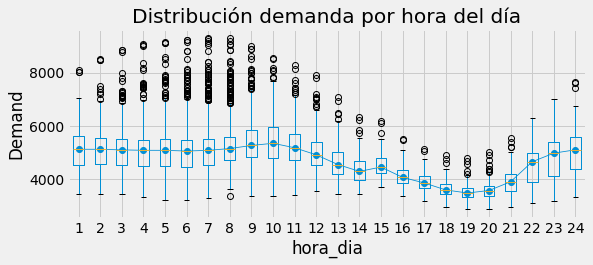

In [36]:
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas